# Import dependencies

In [1]:
import csv
import cv2
import fnmatch
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Dense, Flatten
from keras.models import Sequential
import math
from matplotlib import pyplot
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


# Set parameters

In [2]:
CAMERA_COUNT = 3
DRIVING_LOG_PATH = './data'
DRIVING_LOG_FILE = 'driving_log.csv'
CENTER_IMAGE_REGULAR_EXPRESSION = 'center*'
IMAGE_PATH = './data/IMG'

center_file = 'center_2016_12_01_13_37_16_570.jpg'
left_file = 'left_2016_12_01_13_37_16_570.jpg'
right_file = 'right_2016_12_01_13_37_16_570.jpg'

# Get data

Use data by Udacity.

Source: https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip

Size: 322.8 MB

In [3]:
# Do not execute this cell as it will read all images into memory
# data = np.array([cv2.imread(os.path.join(IMAGE_PATH, file)) for file in os.listdir(IMAGE_PATH)], dtype = 'float32')

# Explore data

In [4]:
file = open(os.path.join(DRIVING_LOG_PATH, DRIVING_LOG_FILE), 'r')
reader = csv.reader(file)

print(reader.__next__())
print(reader.__next__())

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
['IMG/center_2016_12_01_13_30_48_287.jpg', ' IMG/left_2016_12_01_13_30_48_287.jpg', ' IMG/right_2016_12_01_13_30_48_287.jpg', ' 0', ' 0', ' 0', ' 22.14829']


In [5]:
count = len(os.listdir(IMAGE_PATH))

print('Count:', count)
print('Frames:', count / CAMERA_COUNT)

Count: 24108
Frames: 8036.0


In [6]:
data = np.array([1 for file in os.listdir(IMAGE_PATH) if fnmatch.fnmatch(file, CENTER_IMAGE_REGULAR_EXPRESSION)], dtype = 'float32')
print('Center image count:', data.sum())

Center image count: 8036.0


In [7]:
image_center = cv2.imread(os.path.join(IMAGE_PATH, center_file))
print('Shape:', image_center.shape)

Shape: (160, 320, 3)


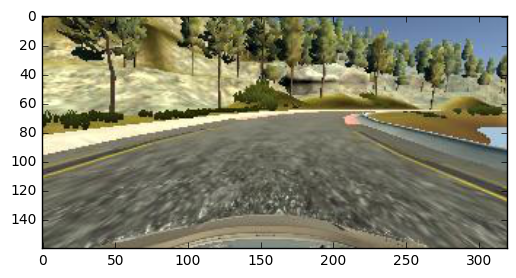

In [8]:
pyplot.imshow(cv2.cvtColor(image_center, cv2.COLOR_BGR2RGB))
pyplot.show()

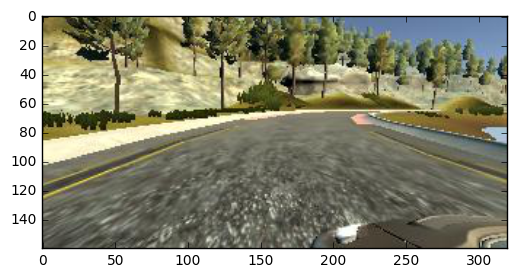

In [9]:
image_left = cv2.imread(os.path.join(IMAGE_PATH, left_file))
pyplot.imshow(cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB))
pyplot.show()

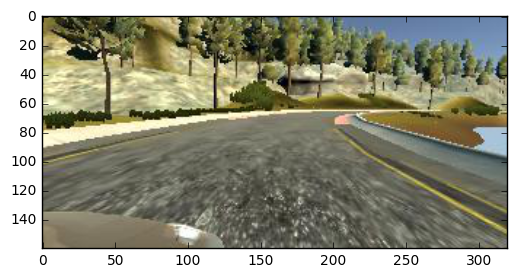

In [10]:
image_right = cv2.imread(os.path.join(IMAGE_PATH, right_file))
pyplot.imshow(cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB))
pyplot.show()

# Transform data

In [11]:
image_center_resized = cv2.resize(image_center, (32, 16))
print('Shape:', image_center_resized.shape)

Shape: (16, 32, 3)


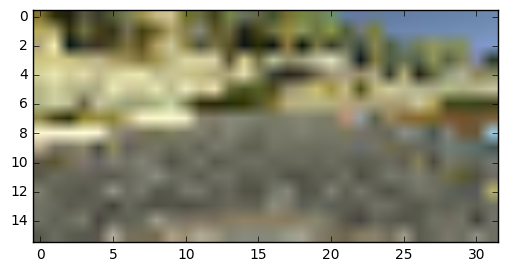

In [12]:
pyplot.imshow(cv2.cvtColor(image_center_resized, cv2.COLOR_BGR2RGB))
pyplot.show()

In [13]:
y_start = 60
y_end = image_center.shape[0] - 20
x_start = 0
x_end = image_center.shape[1]

image_center_cropped = image_center[y_start:y_end, x_start:x_end]
print('Shape:', image_center_cropped.shape)

Shape: (80, 320, 3)


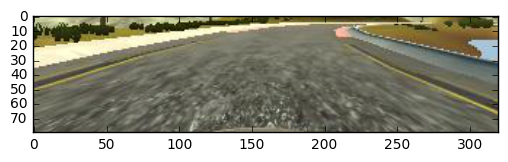

In [14]:
pyplot.imshow(cv2.cvtColor(image_center_cropped, cv2.COLOR_BGR2RGB))
pyplot.show()

In [15]:
image_center_grayscale = cv2.cvtColor(image_center, cv2.COLOR_BGR2GRAY)

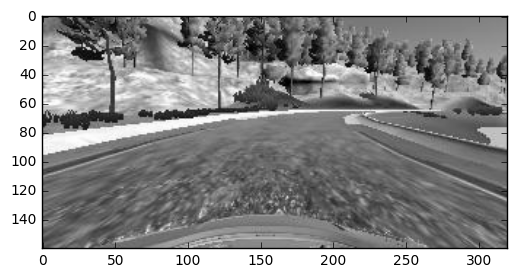

In [16]:
pyplot.imshow(image_center_grayscale, cmap = 'gray')
pyplot.show()

In [17]:
image_center_cropped_grayscale = cv2.cvtColor(image_center_cropped, cv2.COLOR_BGR2GRAY)
image_center_cropped_grayscale_resized = cv2.resize(image_center_cropped_grayscale, (32, 8))

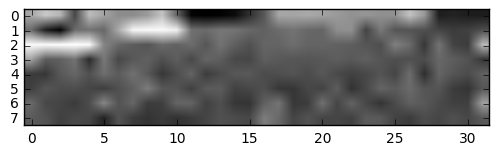

In [18]:
pyplot.imshow(image_center_cropped_grayscale_resized, cmap = 'gray')
pyplot.show()

# Get features and labels

In [19]:
set_size = 3

In [20]:
file = open(os.path.join(DRIVING_LOG_PATH, DRIVING_LOG_FILE), 'r')
reader = csv.reader(file)

reader.__next__()

features = np.array(
    [
        cv2.imread(
            os.path.join(
                IMAGE_PATH,
                reader
                    .__next__()[0]
                    .strip('IMG/')
            )
        )
        for index in range(set_size)
    ],
    dtype = 'float32'
)

In [21]:
file = open(os.path.join(DRIVING_LOG_PATH, DRIVING_LOG_FILE), 'r')
reader = csv.reader(file)

reader.__next__()

labels = np.array(
    [
        reader.__next__()[3]
        for index in range(set_size)
    ],
    dtype = 'float32'
)

# Process features and labels

In [22]:
features, labels = shuffle(features, labels)

In [23]:
def normalize(image_data):
    lower_bound = -0.5
    upper_bound = 0.5
    minimum_pixel = 0
    maximum_pixel = 255
    
    return lower_bound + (
        (image_data - minimum_pixel) *
        (upper_bound - lower_bound) /
        (maximum_pixel - minimum_pixel)
    )

normalized_features = normalize(features)

In [24]:
epsilon = 1e-5

assert math.isclose(
    np.min(normalized_features),
    -0.5,
    abs_tol = epsilon
) and math.isclose(
    np.max(normalized_features),
    0.5,
    abs_tol = epsilon
), 'Range is: {} to {}. It must be -0.5 to 0.5'.format(
    np.min(normalized_features),
    np.max(normalized_features)
)

# Get training and validation set

In [25]:
training_features, validation_features, training_labels, validation_labels = train_test_split(
    normalized_features,
    labels,
    test_size = 0.2,
    random_state = 0
)

In [26]:
print(training_features.shape)
print(training_labels.shape)
print(validation_features.shape)
print(validation_labels.shape)

(2, 160, 320, 3)
(2,)
(1, 160, 320, 3)
(1,)


# Design model

Use model by NVIDIA.

Source: https://arxiv.org/pdf/1604.07316v1.pdf

In [53]:
width = training_features.shape[1]
length = training_features.shape[2]
depth = training_features.shape[3]

In [55]:
# Comment out dimensions from NVIDIA model after testi model output shape
width = 66
length = 200
depth = 3

In [58]:
kernel_row = 5
kernel_column = 5
convolution_filter = 24

model = Sequential()
model.add(Convolution2D(
    convolution_filter,
    kernel_row,
    kernel_column,
    border_mode = 'valid',
    subsample = (2, 2),
    input_shape = (width, length, depth)
))

print(model.output_shape)

(None, 31, 98, 24)


# Train model

# Save model

# Load model

# Evaluate model

# Test model